In [1]:
# import pandas as pd
# import numpy as np
# import geopandas as gpd
import matplotlib.pyplot as plt; 
%matplotlib inline
# from shapely.geometry import Point, Polygon, box

## Area

In [2]:
from shapely.geometry import box
import geopandas as gpd

xmin=0; ymin=0; xmax=1000; ymax=1000
rect = box(xmin, ymin, xmax, ymax)
area1 = gpd.GeoDataFrame({'area_name':['area1'],
                          'visibility': [0.90],
                          'geometry': rect}, 
                         geometry='geometry'
                        )
area1

,area_name,visibility,geometry
0,area1,0.9,"POLYGON ((1000 0, 1000 1000, 0 1000, 0 0, 1000..."


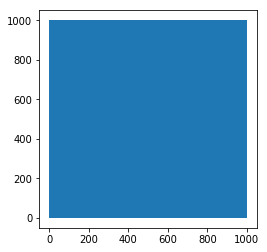

In [3]:
area1.plot()

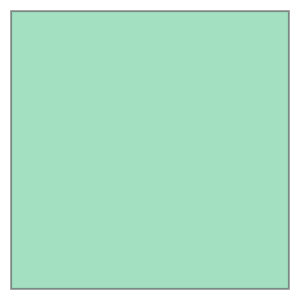

In [4]:
area1.geometry[0].minimum_rotated_rectangle

## Coverage

### Transects

maximize for the longest single transect?
maximize for total survey area? need to buffer before calculating this

In [5]:
def make_transects(transect_interval, sweep_width, angle_degrees, area_gdf, sec_per_unit_dist):
    import numpy as np
    import geopandas as gpd
    from shapely.geometry import LineString

    xmin = area_gdf.bounds.minx.min()
    xmax = area_gdf.bounds.maxx.max()
    ymin = area_gdf.bounds.miny.min()
    ymax = area_gdf.bounds.maxy.max()

    h = ymax-ymin

    def standard(temp_angle):
        theta = np.radians(temp_angle)
        horiz_shift = (1/np.cos(theta)) * transect_interval
        top_start = xmin
        
        # calculate bottom starting point
        a = (1/np.tan(theta)) * transect_interval
        b = h - a
        bottom_start_shift = np.tan(theta) * b
        bottom_start = xmin - bottom_start_shift
        
        n_transects = int((xmax - bottom_start) / horiz_shift)
        
        offsets = np.arange(1, n_transects+1) * horiz_shift
        top_vals  = top_start + offsets
        bottom_vals = bottom_start + offsets
        
        return top_vals, bottom_vals, n_transects
    
    def special(horiz_shift, top_start, bottom_start):
        n_transects = int((xmax - bottom_start) / horiz_shift)
    
        offsets = np.arange(1, n_transects+1) * horiz_shift
        top_vals  = top_start + offsets
        bottom_vals = bottom_start + offsets
        
        return top_vals, bottom_vals, n_transects


    if 0 < angle_degrees < 90:
        top_vals, bottom_vals, n_transects = standard(angle_degrees)
        
    elif 90 < angle_degrees < 180:
        supplement = 180 - angle_degrees
        bottom_vals, top_vals, n_transects = standard(supplement)
        
    elif angle_degrees in [0, 180]:
        horiz_shift = transect_interval
        top_start = xmin + sweep_width
        bottom_start = top_start
        top_vals, bottom_vals, n_transects = special(horiz_shift, top_start, bottom_start)
    
    elif angle_degrees == 90:
        horiz_shift = transect_interval
        top_start = ymin + sweep_width
        bottom_start = top_start
        top_vals, bottom_vals, n_transects = special(horiz_shift, top_start, bottom_start)
    
    top_coords = list(zip(top_vals, np.full_like(top_vals, fill_value=ymax)))
    bottom_coords = list(zip(bottom_vals, np.full_like(bottom_vals, fill_value=ymin)))

    lines_gs = gpd.GeoSeries([LineString(coord_pair) for coord_pair in zip(top_coords, bottom_coords)])
    lines_gdf = gpd.GeoDataFrame({'length': np.arange(0, n_transects),
                                  'geometry': lines_gs
                                 }, geometry='geometry')
    
    # clip lines by area
    poly = area1.geometry.unary_union
    spatial_index = lines_gdf.sindex
    bbox = poly.bounds
    sidx = list(spatial_index.intersection(bbox))
    lines_sub = lines_gdf.iloc[sidx]
    clipped = lines_sub.copy()
    clipped['geometry'] = lines_sub.intersection(poly)
    lines_clipped = clipped[clipped.geometry.notnull()]
    
    
    transects_buffer = lines_clipped.buffer(sweep_width)  # buffer transects
    buffer_gdf = gpd.GeoDataFrame({'angle_deg':[angle_degrees] * n_transects,
                                   'length': lines_clipped.length,
                                   'geometry': transects_buffer}, 
                                   geometry='geometry')

    transects = gpd.overlay(buffer_gdf, area_gdf, how='intersection')
    transects['area'] = transects.area
    transects['min_search_time'] = sec_per_unit_dist * transects['length']
    # add su_id column
    transects['su_id'] = [i for i in range(transects.shape[0])]
    transects = transects.loc[:, ['su_id', 'angle_deg', 'length', 'area_name', 'visibility', 'geometry', 'area', 'min_search_time']]
    
    return transects

In [6]:
def compare_transect_angles(transect_interval, sweep_width, area_gdf, sec_per_unit_dist):
    import pandas as pd
    
    df_list=[]
    for angle in range(0, 180, 5):
        df = make_transects(transect_interval, sweep_width, angle, area_gdf, sec_per_unit_dist)
        df_list.append(df)
    
    angle_df = pd.concat(df_list)
    
#     return angle_df
    return angle_df.groupby('angle_deg')['area'].sum()

humans' preferred walking speed is 1.4 m/sec

In [7]:
compare_transect_angles(10, 2, area1, 72)

,su_id,angle_deg,length,area_name,visibility,geometry,area,min_search_time
0,0,0,1000.000000,area1,0.9,"POLYGON ((710 0, 710 1000, 714 1000, 714 0, 71...",4000.000000,72000.000000
1,1,0,1000.000000,area1,0.9,"POLYGON ((720 0, 720 1000, 724 1000, 724 0, 72...",4000.000000,72000.000000
2,2,0,1000.000000,area1,0.9,"POLYGON ((730 0, 730 1000, 734 1000, 734 0, 73...",4000.000000,72000.000000
3,3,0,1000.000000,area1,0.9,"POLYGON ((740 0, 740 1000, 744 1000, 744 0, 74...",4000.000000,72000.000000
4,4,0,1000.000000,area1,0.9,"POLYGON ((750 0, 750 1000, 754 1000, 754 0, 75...",4000.000000,72000.000000
5,5,0,1000.000000,area1,0.9,"POLYGON ((760 0, 760 1000, 764 1000, 764 0, 76...",4000.000000,72000.000000
6,6,0,1000.000000,area1,0.9,"POLYGON ((770 0, 770 1000, 774 1000, 774 0, 77...",4000.000000,72000.000000
7,7,0,1000.000000,area1,0.9,"POLYGON ((780 0, 780 1000, 784 1000, 784 0, 78...",4000.000000,72000.000000
8,8,0,1000.000000,area1,0.9,"POLYGON ((790 0, 790 1000, 794 1000, 794 0, 79...",4000.000000,72000.000000
9,9,0,1000.000000,area1,0.9,"POLYGON ((800 0, 800 1000, 804 1000, 804 0, 80...",4000.000000,72000.000000


In [8]:
coverage = make_transects(10, 2, 85, area1, 72)

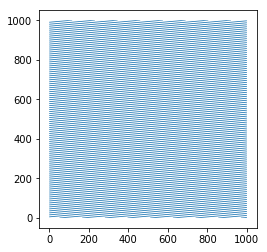

In [9]:
coverage.plot();

In [10]:
coverage.head()

,su_id,angle_deg,length,area_name,visibility,geometry,area,min_search_time
0,0,85,1003.826517,area1,0.9,POLYGON ((0.1744629608676688 284.6714509220678...,4015.304569,72275.509254
1,1,85,1003.826517,area1,0.9,POLYGON ((0.1744629608676688 274.6244625708012...,4015.304569,72275.509254
2,2,85,1003.826517,area1,0.9,POLYGON ((0.1744629608676688 264.5774742195347...,4015.304569,72275.509254
3,3,85,1003.826517,area1,0.9,POLYGON ((0.1744629608676688 254.5304858682681...,4015.304569,72275.509254
4,4,85,1003.826517,area1,0.9,POLYGON ((0.1744629608676688 244.4834975170014...,4015.304569,72275.509254


## Assemblage

### Layer 1

In [11]:
from numpy.random import random
from shapely.geometry import Point
import geopandas as gpd
import pandas as pd

n = 250
xrange=(0, 1000); yrange=(0, 1000)

xs = (random(n) * (xrange[1] - xrange[0])) + xrange[0]
ys = (random(n) * (yrange[1] - yrange[0])) + yrange[0]
gds = gpd.GeoSeries([Point(xy) for xy in zip(xs, ys)])

ceramics = gpd.GeoDataFrame({'layer_name': ['ceramics'] * n,
                           'fid': [f'ceramics_{i}' for i in range(n)],
                           'time_penalty': [0.1] * n,
                           'ideal_obs_rate': [0.95] * n,
                           'geometry': gds},
                          geometry = 'geometry'
                         )
ceramics

,layer_name,fid,time_penalty,ideal_obs_rate,geometry
0,ceramics,ceramics_0,0.1,0.95,POINT (81.07723887827845 584.3094422031965)
1,ceramics,ceramics_1,0.1,0.95,POINT (656.9513889594177 393.5740383305121)
2,ceramics,ceramics_2,0.1,0.95,POINT (951.3087016514129 709.550240548204)
3,ceramics,ceramics_3,0.1,0.95,POINT (755.0036473921909 452.0194073429077)
4,ceramics,ceramics_4,0.1,0.95,POINT (117.8998995619357 69.3843571602728)
5,ceramics,ceramics_5,0.1,0.95,POINT (462.2106490246964 9.140291785116661)
6,ceramics,ceramics_6,0.1,0.95,POINT (904.3227507923035 396.4069533593598)
7,ceramics,ceramics_7,0.1,0.95,POINT (777.2133553750597 500.2680147056211)
8,ceramics,ceramics_8,0.1,0.95,POINT (461.4145272432659 111.3665607082811)
9,ceramics,ceramics_9,0.1,0.95,POINT (526.1882395431085 678.0608549145536)


### Layer 2

In [12]:
n = 200
xrange=(0, 1000); yrange=(0, 1000)

xs = (random(n) * (xrange[1] - xrange[0])) + xrange[0]
ys = (random(n) * (yrange[1] - yrange[0])) + yrange[0]
gds = gpd.GeoSeries([Point(xy) for xy in zip(xs, ys)])

lithics = gpd.GeoDataFrame({'layer_name': ['lithics'] * n,
                           'fid': [f'lithics_{i}' for i in range(n)],
                           'time_penalty': [0.15] * n,
                           'ideal_obs_rate': [0.80] * n,
                           'geometry': gds},
                          geometry = 'geometry'
                         )
lithics

,layer_name,fid,time_penalty,ideal_obs_rate,geometry
0,lithics,lithics_0,0.15,0.8,POINT (197.0704550620749 730.9659698364641)
1,lithics,lithics_1,0.15,0.8,POINT (913.6944353584588 82.31298597079551)
2,lithics,lithics_2,0.15,0.8,POINT (843.5735760240503 798.729687392037)
3,lithics,lithics_3,0.15,0.8,POINT (122.9918060219495 531.5142048953514)
4,lithics,lithics_4,0.15,0.8,POINT (713.718487809108 7.140506387117607)
5,lithics,lithics_5,0.15,0.8,POINT (436.9083132747509 726.1704013276428)
6,lithics,lithics_6,0.15,0.8,POINT (70.28370741228539 853.8545767626365)
7,lithics,lithics_7,0.15,0.8,POINT (624.5372592460018 973.3996042127591)
8,lithics,lithics_8,0.15,0.8,POINT (37.96735725634759 210.3057120341997)
9,lithics,lithics_9,0.15,0.8,POINT (683.0503473083963 864.679887725452)


In [13]:
assemblage = pd.concat([ceramics, lithics], ignore_index=True)
assemblage

,layer_name,fid,time_penalty,ideal_obs_rate,geometry
0,ceramics,ceramics_0,0.10,0.95,POINT (81.07723887827845 584.3094422031965)
1,ceramics,ceramics_1,0.10,0.95,POINT (656.9513889594177 393.5740383305121)
2,ceramics,ceramics_2,0.10,0.95,POINT (951.3087016514129 709.550240548204)
3,ceramics,ceramics_3,0.10,0.95,POINT (755.0036473921909 452.0194073429077)
4,ceramics,ceramics_4,0.10,0.95,POINT (117.8998995619357 69.3843571602728)
5,ceramics,ceramics_5,0.10,0.95,POINT (462.2106490246964 9.140291785116661)
6,ceramics,ceramics_6,0.10,0.95,POINT (904.3227507923035 396.4069533593598)
7,ceramics,ceramics_7,0.10,0.95,POINT (777.2133553750597 500.2680147056211)
8,ceramics,ceramics_8,0.10,0.95,POINT (461.4145272432659 111.3665607082811)
9,ceramics,ceramics_9,0.10,0.95,POINT (526.1882395431085 678.0608549145536)


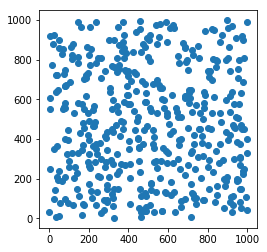

In [14]:
assemblage.plot()

## Team

In [15]:
import pandas as pd

team = pd.DataFrame({'surveyor_type': ['pi', 'grad', 'undergrad', 'undergrad', 'undergrad'],
                     'skill': [1.0, 0.95, 0.85, 0.85, 0.85],
                     'speed_penalty': [0.0, 0.0, 0.2, 0.2, 0.2]
                    })

for stype in team['surveyor_type'].unique():
    stype_df = team.loc[team['surveyor_type']==stype, :]
    team.loc[stype_df.index, 'sid'] = [i for i in range(stype_df.shape[0])]

team['sid'] = team.apply(lambda x: x['surveyor_type'] + '_' + str(int(x['sid'])), axis=1)
team = team.loc[:, ['sid', 'surveyor_type', 'skill', 'speed_penalty']]
team

,sid,surveyor_type,skill,speed_penalty
0,pi_0,pi,1.00,0.0
1,grad_0,grad,0.95,0.0
2,undergrad_0,undergrad,0.85,0.2
3,undergrad_1,undergrad,0.85,0.2
4,undergrad_2,undergrad,0.85,0.2


In [16]:
import pandas as pd
s1 = pd.Series(['a', 'b'])
s2 = pd.Series(['c', 'd'])
df = pd.DataFrame(pd.concat([s1, s2]).reset_index(drop=True))
df = df.drop(df[df[0]=='b'].index)
# df = df.loc[df[0]!='b']
df

,0
0,a
2,c
3,d


In [16]:
team

,sid,surveyor_type,skill,speed_penalty
0,pi_0,pi,1.00,0.0
1,grad_0,grad,0.95,0.0
2,undergrad_0,undergrad,0.85,0.2
3,undergrad_1,undergrad,0.85,0.2
4,undergrad_2,undergrad,0.85,0.2


## Putting it all together

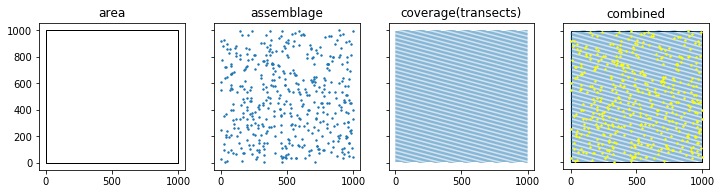

In [17]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(12, 3))
area1.plot(ax=ax1, edgecolor='black', color='white').set_title('area')
assemblage.plot(ax=ax2, markersize=2).set_title('assemblage')
coverage.plot(ax=ax3).set_title('coverage(transects)')
area1.plot(ax=ax4, edgecolor='black', color='white')
coverage.plot(ax=ax4)
assemblage.plot(ax=ax4, color='yellow', markersize=2).set_title('combined');

In [30]:
area1.head()

,area_name,visibility,geometry
0,area1,0.9,"POLYGON ((1000 0, 1000 1000, 0 1000, 0 0, 1000..."


In [31]:
assemblage.head()

,layer_name,fid,time_penalty,ideal_obs_rate,geometry
0,ceramics,ceramics_0,0.1,0.95,POINT (81.07723887827845 584.3094422031965)
1,ceramics,ceramics_1,0.1,0.95,POINT (656.9513889594177 393.5740383305121)
2,ceramics,ceramics_2,0.1,0.95,POINT (951.3087016514129 709.550240548204)
3,ceramics,ceramics_3,0.1,0.95,POINT (755.0036473921909 452.0194073429077)
4,ceramics,ceramics_4,0.1,0.95,POINT (117.8998995619357 69.3843571602728)


In [32]:
coverage.head()

,su_id,angle_deg,length,area_name,visibility,geometry,area,min_search_time
0,0,85,1003.826517,area1,0.9,POLYGON ((0.1744629608676688 284.6714509220678...,4015.304569,72275.509254
1,1,85,1003.826517,area1,0.9,POLYGON ((0.1744629608676688 274.6244625708012...,4015.304569,72275.509254
2,2,85,1003.826517,area1,0.9,POLYGON ((0.1744629608676688 264.5774742195347...,4015.304569,72275.509254
3,3,85,1003.826517,area1,0.9,POLYGON ((0.1744629608676688 254.5304858682681...,4015.304569,72275.509254
4,4,85,1003.826517,area1,0.9,POLYGON ((0.1744629608676688 244.4834975170014...,4015.304569,72275.509254


In [33]:
team.head()

,sid,surveyor_type,skill,speed_penalty
0,pi_0,pi,1.00,0.0
1,grad_0,grad,0.95,0.0
2,undergrad_0,undergrad,0.85,0.2
3,undergrad_1,undergrad,0.85,0.2
4,undergrad_2,undergrad,0.85,0.2


### allocate surveyors to transects

In [18]:
# x.apply(lambda col: col*y)

In [19]:
import math
from scipy.optimize import linear_sum_assignment

multiplier = math.ceil(coverage.shape[0] / team.shape[0])  # roughly how many survey units for each surveyor

# duplicate this `multiplier` number of times
# this way, you have a way to tie index back to id
dummy_team = pd.concat([team]*multiplier).reset_index().rename(columns={'index': 'prev_idx'})  # repeat team_df until >= len(coverage)

cost = coverage['min_search_time'].apply(lambda x: x + x*dummy_team['speed_penalty']).T  # create large coost table
cost = cost.iloc[:cost.shape[1]]  # remove extra rows

solution = linear_sum_assignment(cost)  # run linear sum assignment

assignments = pd.DataFrame({'dummy_sid': solution[0], 'dummy_su_id': solution[1]})  # turn results into df

coverage_assigned = coverage.merge(assignments, how='left', left_on='su_id', right_on='dummy_su_id')  # merge assignments to coverage
coverage_assigned = coverage_assigned.merge(dummy_team, how='left', left_on='dummy_sid', right_index=True)  # get actual surveyor info attached
coverage_assigned.drop(columns = ['dummy_sid', 'dummy_su_id', 'prev_idx'], inplace=True)
coverage_assigned['time_pre_search'] = coverage_assigned['min_search_time'] + coverage_assigned['min_search_time']*coverage_assigned['speed_penalty']

In [20]:
coverage_assigned.head(10)

,su_id,angle_deg,length,area_name,visibility,geometry,area,min_search_time,sid,surveyor_type,skill,speed_penalty,time_pre_search
0,0,85,1003.826517,area1,0.9,POLYGON ((0.1744629608676688 284.6714509220678...,4015.304569,72275.509254,undergrad_0,undergrad,0.85,0.2,86730.611105
1,1,85,1003.826517,area1,0.9,POLYGON ((0.1744629608676688 274.6244625708012...,4015.304569,72275.509254,grad_0,grad,0.95,0.0,72275.509254
2,2,85,1003.826517,area1,0.9,POLYGON ((0.1744629608676688 264.5774742195347...,4015.304569,72275.509254,pi_0,pi,1.00,0.0,72275.509254
3,3,85,1003.826517,area1,0.9,POLYGON ((0.1744629608676688 254.5304858682681...,4015.304569,72275.509254,undergrad_2,undergrad,0.85,0.2,86730.611105
4,4,85,1003.826517,area1,0.9,POLYGON ((0.1744629608676688 244.4834975170014...,4015.304569,72275.509254,undergrad_1,undergrad,0.85,0.2,86730.611105
5,5,85,1003.826517,area1,0.9,POLYGON ((0.1744629608676689 234.4365091657349...,4015.304569,72275.509254,undergrad_0,undergrad,0.85,0.2,86730.611105
6,6,85,1003.826517,area1,0.9,POLYGON ((0.1744629608676688 224.3895208144682...,4015.304569,72275.509254,grad_0,grad,0.95,0.0,72275.509254
7,7,85,1003.826517,area1,0.9,POLYGON ((0.1744629608676689 214.3425324632015...,4015.304569,72275.509254,pi_0,pi,1.00,0.0,72275.509254
8,8,85,1003.826517,area1,0.9,POLYGON ((0.1744629608676688 204.2955441119351...,4015.304569,72275.509254,undergrad_2,undergrad,0.85,0.2,86730.611105
9,9,85,1003.826517,area1,0.9,POLYGON ((0.1744629608676688 194.2485557606684...,4015.304569,72275.509254,undergrad_1,undergrad,0.85,0.2,86730.611105


In [21]:
coverage_assigned.groupby('sid')['time_pre_search'].sum()

sid
grad_0         1.590061e+06
pi_0           1.590061e+06
undergrad_0    1.663773e+06
undergrad_1    1.577043e+06
undergrad_2    1.574212e+06
Name: time_pre_search, dtype: float64

### find which artifacts intersect which transect

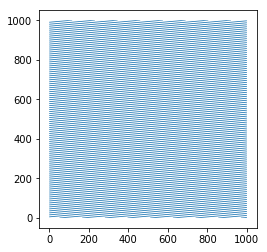

In [22]:
import geopandas as gpd
coverage_assigned.plot()

In [23]:
# use spatial join
# `how='left'` leaves only the artifacts that DO intersect
assemblage_coverage_intersect = gpd.sjoin(assemblage, coverage_assigned, how="inner", op='intersects')
assemblage_coverage_intersect.head()

,layer_name,fid,time_penalty,ideal_obs_rate,geometry,index_right,su_id,angle_deg,length,area_name,visibility,area,min_search_time,sid,surveyor_type,skill,speed_penalty,time_pre_search
0,ceramics,ceramics_0,0.1,0.95,POINT (81.07723887827845 584.3094422031965),79,79,85,1003.826517,area1,0.9,4015.304569,72275.509254,undergrad_1,undergrad,0.85,0.2,86730.611105
1,ceramics,ceramics_1,0.1,0.95,POINT (656.9513889594177 393.5740383305121),103,103,85,1003.826517,area1,0.9,4015.304569,72275.509254,undergrad_2,undergrad,0.85,0.2,86730.611105
3,ceramics,ceramics_3,0.1,0.95,POINT (755.0036473921909 452.0194073429077),98,98,85,1003.826517,area1,0.9,4015.304569,72275.509254,undergrad_2,undergrad,0.85,0.2,86730.611105
158,ceramics,ceramics_158,0.1,0.95,POINT (623.0322754354879 441.3444994064229),98,98,85,1003.826517,area1,0.9,4015.304569,72275.509254,undergrad_2,undergrad,0.85,0.2,86730.611105
248,ceramics,ceramics_248,0.1,0.95,POINT (93.11599952287463 396.577477774505),98,98,85,1003.826517,area1,0.9,4015.304569,72275.509254,undergrad_2,undergrad,0.85,0.2,86730.611105


In [24]:
assemblage_coverage_intersect.shape

(185, 18)

### apply visibility factor

In [25]:
# draw from student t distribution
# if value above threshold, set visibility_factor = False
from scipy.stats import t
random_t_vis = t.rvs(df=assemblage_coverage_intersect.shape[0]-1, size=assemblage_coverage_intersect.shape[0])	
assemblage_coverage_intersect['vis_prob'] = t.cdf(random_t_vis, df=len(random_t_vis)-1)

In [26]:
assemblage_coverage_intersect.head()

,layer_name,fid,time_penalty,ideal_obs_rate,geometry,index_right,su_id,angle_deg,length,area_name,visibility,area,min_search_time,sid,surveyor_type,skill,speed_penalty,time_pre_search,vis_prob
0,ceramics,ceramics_0,0.1,0.95,POINT (81.07723887827845 584.3094422031965),79,79,85,1003.826517,area1,0.9,4015.304569,72275.509254,undergrad_1,undergrad,0.85,0.2,86730.611105,0.854238
1,ceramics,ceramics_1,0.1,0.95,POINT (656.9513889594177 393.5740383305121),103,103,85,1003.826517,area1,0.9,4015.304569,72275.509254,undergrad_2,undergrad,0.85,0.2,86730.611105,0.797385
3,ceramics,ceramics_3,0.1,0.95,POINT (755.0036473921909 452.0194073429077),98,98,85,1003.826517,area1,0.9,4015.304569,72275.509254,undergrad_2,undergrad,0.85,0.2,86730.611105,0.680502
158,ceramics,ceramics_158,0.1,0.95,POINT (623.0322754354879 441.3444994064229),98,98,85,1003.826517,area1,0.9,4015.304569,72275.509254,undergrad_2,undergrad,0.85,0.2,86730.611105,0.756056
248,ceramics,ceramics_248,0.1,0.95,POINT (93.11599952287463 396.577477774505),98,98,85,1003.826517,area1,0.9,4015.304569,72275.509254,undergrad_2,undergrad,0.85,0.2,86730.611105,0.428859


In [27]:
# apply ideal_obs_rate
random_t_obs = t.rvs(df=assemblage_coverage_intersect.shape[0]-1, size=assemblage_coverage_intersect.shape[0])	
assemblage_coverage_intersect['ideal_obs_prob'] = t.cdf(random_t_obs, df=len(random_t_obs)-1)

In [28]:
assemblage_coverage_intersect.head()

,layer_name,fid,time_penalty,ideal_obs_rate,geometry,index_right,su_id,angle_deg,length,area_name,visibility,area,min_search_time,sid,surveyor_type,skill,speed_penalty,time_pre_search,vis_prob,ideal_obs_prob
0,ceramics,ceramics_0,0.1,0.95,POINT (81.07723887827845 584.3094422031965),79,79,85,1003.826517,area1,0.9,4015.304569,72275.509254,undergrad_1,undergrad,0.85,0.2,86730.611105,0.854238,0.958544
1,ceramics,ceramics_1,0.1,0.95,POINT (656.9513889594177 393.5740383305121),103,103,85,1003.826517,area1,0.9,4015.304569,72275.509254,undergrad_2,undergrad,0.85,0.2,86730.611105,0.797385,0.038996
3,ceramics,ceramics_3,0.1,0.95,POINT (755.0036473921909 452.0194073429077),98,98,85,1003.826517,area1,0.9,4015.304569,72275.509254,undergrad_2,undergrad,0.85,0.2,86730.611105,0.680502,0.918568
158,ceramics,ceramics_158,0.1,0.95,POINT (623.0322754354879 441.3444994064229),98,98,85,1003.826517,area1,0.9,4015.304569,72275.509254,undergrad_2,undergrad,0.85,0.2,86730.611105,0.756056,0.286376
248,ceramics,ceramics_248,0.1,0.95,POINT (93.11599952287463 396.577477774505),98,98,85,1003.826517,area1,0.9,4015.304569,72275.509254,undergrad_2,undergrad,0.85,0.2,86730.611105,0.428859,0.696091


In [ ]:
# apply surveyor skill

In [ ]:
# add time based on surveyor speed

In [ ]:
# add time penalty for finds to transect

In [ ]:
# compare assemblage to finds